Can I automateish the line measurements?

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import astropy.io.fits as fits
import os
from scipy.io.idl import readsav
from astropy.table import Table
from astropy.io import ascii
import astropy.units as u
import astropy.constants as const
from astropy.modeling import models, fitting
from craftroom import resample
from scipy.interpolate import interp1d
from astropy.convolution import convolve, Box1DKernel


%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20

In [2]:
linelist = Table.read('/home/david/work/muscles/SEDs/lines/FUV_linelist.csv')

In [4]:
t1data = Table.read('../../common/quicksaves/2MASS-J23062928-0502285_basic.ecsv')

In [5]:
w, f , e = np.array(t1data['WAVELENGTH']), np.array(t1data['FLUX']), np.array(t1data['ERROR'])

In [6]:
cos_cut = (w > 1100) & (w < 1210) | (w > 1220) & (w < 3100) 
w, f, e = w[cos_cut], f[cos_cut], e[cos_cut]

In [13]:
mw = np.arange(w[0], w[-1], 0.01)

In [8]:
high = linelist[linelist['Likelihood to measure'] =='High'] 

(1600.0, 1700.0)

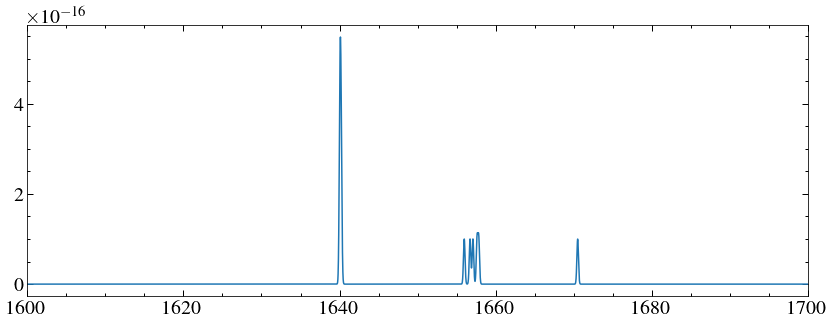

In [33]:
dv = -56.3*u.km/u.s

m_init = models.Const1D(0)
for line in high['Wavelength']:
    li = dv.to(u.AA, equivalencies=u.doppler_optical(line*u.AA)).value
    m_init+= models.Gaussian1D(1e-16, li, 0.1, fixed=dict(mean=True, stddev=True))
    
plt.plot(mw, m_init(mw))
plt.xlim(1600, 1700)    

In [17]:
smooth = 5
f1 = convolve(f,Box1DKernel(smooth))
e1 = convolve(e,Box1DKernel(smooth))/smooth**0.5

In [18]:
fitter = fitting.LevMarLSQFitter()

In [34]:
m_fit = fitter(m_init, w, f1, weights = 1/e1, maxiter=10000)

/home/david/anaconda3/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.
/home/david/anaconda3/envs/astroconda/lib/python3.6/site-packages/astropy/modeling/fitting.py:831: RuntimeWarning: invalid value encountered in multiply
  return np.ravel(weights * (model(*args[2: -1]) - meas))


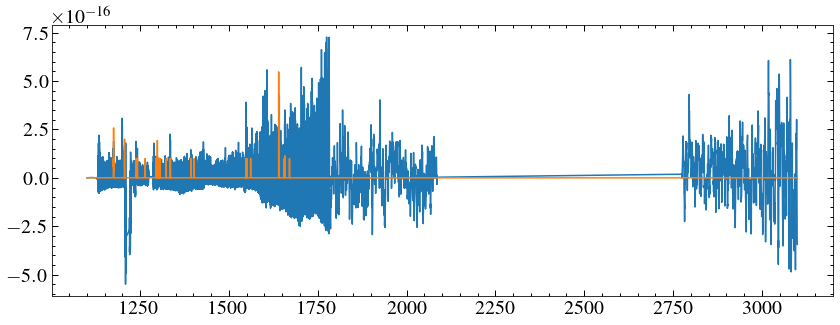

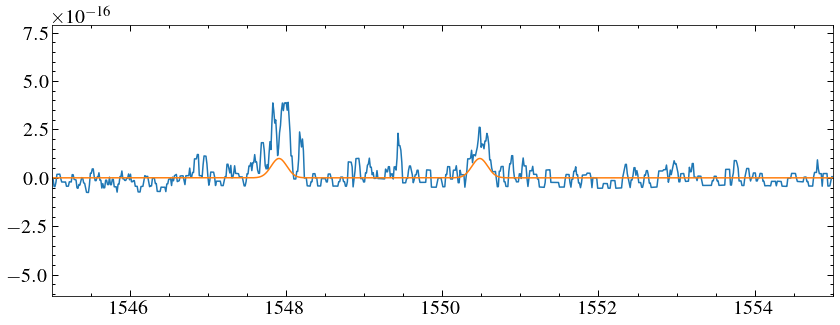

In [36]:
plt.plot(w, f1)
plt.plot(mw, m_fit(mw))
plt.show()

plt.plot(w, f1)
plt.plot(mw, m_fit(mw))
plt.xlim(1545, 1555)
plt.show()